# Sentiment Pipeline Walkthrough
This notebook reproduces the end-to-end workflow from `main_bis.py`, with explanations attached to each stage.


## Roadmap
1. Configure paths, dependencies, and experiment options.
2. Load and inspect the tweet corpus.
3. Build tokenisation and vocabulary utilities.
4. Encode datasets and prepare PyTorch dataloaders.
5. Define the sequence classifier (RNN/LSTM).
6. Add evaluation, training, and early-stopping helpers.
7. Run the full set of experiments and review predictions.


## Imports and Global Configuration
The following cell collects standard library helpers and PyTorch components. Logging mirrors the CLI implementation.


In [1]:
import argparse  # noqa: F401 (kept for parity with the script)
import json
import logging
import random
import re
from collections import Counter, deque
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
LOGGER = logging.getLogger('notebook-trainer')
LOGGER.setLevel(logging.INFO)
LOGGER.info('PyTorch version: %s', torch.__version__)


[INFO] PyTorch version: 2.8.0+cu128


## Experiment Options
Set the configuration knobs you normally pass on the command line. Feel free to tweak values (e.g. disable previews or cap sample counts) before running the training cell.


In [2]:
DATA_PATH = Path('corpus.json')
OPTIONS = {
    'max_vocab_size': 30000,
    'min_freq': 2,
    'batch_size': 128,
    'epochs': 5,
    'embedding_dim': 128,
    'hidden_size': 128,
    'mlp_hidden': 128,
    'num_layers': 1,
    'dropout': 0.3,
    'lr': 1e-3,
    'max_samples': 0,  # 0 = use the full corpus
    'seed': 42,
    'early_stop_patience': 0,
    'early_stop_window': 3,
    'early_stop_min_delta': 0.0,
    'max_grad_norm': 5.0,
    'bidirectional': True,
    'preview_samples': 3,
    'no_preview': False,
}
LOGGER.info('Configuration: %s', OPTIONS)


[INFO] Configuration: {'max_vocab_size': 30000, 'min_freq': 2, 'batch_size': 128, 'epochs': 5, 'embedding_dim': 128, 'hidden_size': 128, 'mlp_hidden': 128, 'num_layers': 1, 'dropout': 0.3, 'lr': 0.001, 'max_samples': 0, 'seed': 42, 'early_stop_patience': 0, 'early_stop_window': 3, 'early_stop_min_delta': 0.0, 'max_grad_norm': 5.0, 'bidirectional': True, 'preview_samples': 3, 'no_preview': False}


## Load and Inspect the Corpus
We ingest the JSON list once, apply the random seed for reproducibility, and take a quick peek at the structure.


In [3]:
random.seed(OPTIONS['seed'])
torch.manual_seed(OPTIONS['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(OPTIONS['seed'])

with DATA_PATH.open(encoding='utf-8') as f:
    CORPUS: List[Dict[str, Any]] = json.load(f)

LOGGER.info('Loaded %d samples.', len(CORPUS))
CORPUS[0]


[INFO] Loaded 500000 samples.


{'text': 'this is not good       sore throat, head ache, stuffy nose - what are the symptoms of swine flu again?',
 'target': 'negative',
 'lemmatized_text': 'this be not good sore throat , head ache , stuffy nose - what be the symptom of swine flu again ?'}

## Label Mapping
Targets are "positive"/"negative". The mapping below lets us convert between human-readable labels and numeric targets.


In [4]:
LABEL2ID = {'negative': 0, 'positive': 1}
ID2LABEL = {idx: label for label, idx in LABEL2ID.items()}
LABEL2ID, ID2LABEL


({'negative': 0, 'positive': 1}, {0: 'negative', 1: 'positive'})

## Tokenisation and Vocabulary
The regex-based tokenizer mirrors the CLI script. `Vocab` keeps `<pad>` and `<unk>` slots and restricts the vocabulary size/frequency.


In [5]:
TOKEN_PATTERN = re.compile(r'\w+|[^\w\s]')

def tokenize(text: str) -> List[str]:
    """Lowercase tokenization that preserves punctuation as separate tokens."""
    return TOKEN_PATTERN.findall(text.lower())

class Vocab:
    """Frequency-based vocabulary with special PAD/UNK handling."""

    def __init__(self, counter: Counter, max_size: Optional[int], min_freq: int) -> None:
        base = ['<pad>', '<unk>']
        tokens = [tok for tok, freq in counter.most_common() if freq >= min_freq and tok not in base]
        limit = (max_size or 0) - len(base)
        if limit > 0:
            tokens = tokens[:limit]
        self.itos = base + tokens
        self.stoi = {tok: idx for idx, tok in enumerate(self.itos)}
        self.pad_idx = self.stoi['<pad>']
        self.unk_idx = self.stoi['<unk>']

    def encode(self, tokens: Sequence[str]) -> List[int]:
        return [self.stoi.get(tok, self.unk_idx) for tok in tokens]

    @property
    def size(self) -> int:
        return len(self.itos)

def build_vocab(texts: Iterable[str], max_size: Optional[int], min_freq: int) -> Vocab:
    """Construct a vocabulary from an iterable of raw texts."""
    counter = Counter(tok for text in texts for tok in tokenize(text))
    return Vocab(counter, max_size, min_freq)


## Encoding Samples and Batching
We convert (text, label) pairs into integer id sequences, then build a collate function that pads batches for the RNN.


In [6]:
def encode_samples(samples: Sequence[Tuple[str, int]], vocab: Vocab) -> List[Tuple[List[int], int]]:
    """Tokenise and numericalise each example, falling back to UNK when empty."""
    encoded: List[Tuple[List[int], int]] = []
    for text, label in samples:
        ids = vocab.encode(tokenize(text))
        if not ids:
            ids = [vocab.unk_idx]
        encoded.append((ids, label))
    return encoded

def collate_batch(batch: Sequence[Tuple[List[int], int]], pad_idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Pad a batch of variable-length sequences and return tensors for tokens/lengths/labels."""
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in sequences], batch_first=True, padding_value=pad_idx)
    return padded, lengths, torch.tensor(labels, dtype=torch.long)


## Sequence Classifier
The model embeds tokens, feeds them through an RNN/LSTM stack, concatenates the final states, and finishes with a small MLP classifier.


In [7]:
class SequenceClassifier(nn.Module):
    """RNN/LSTM encoder paired with an MLP head for sentiment classification."""

    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_size: int,
        *,
        rnn_type: str,
        num_layers: int,
        dropout: float,
        bidirectional: bool,
        pad_idx: int,
        mlp_hidden: int,
    ) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        rnn_cls = nn.LSTM if rnn_type.lower() == 'lstm' else nn.RNN
        self.encoder = rnn_cls(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        factor = 2 if bidirectional else 1
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * factor, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, len(LABEL2ID)),
        )

    def forward(self, tokens: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        embedded = self.embed(tokens)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        hidden = self.encoder(packed)[1]
        hidden = hidden[0] if isinstance(hidden, tuple) else hidden
        hidden = hidden[-2:] if hidden.size(0) > 1 else hidden[-1:]
        features = hidden.transpose(0, 1).reshape(tokens.size(0), -1)
        return self.classifier(features)


## Early Stopping Helper
We maintain a moving average of recent validation losses to dampen noise; training halts once the average fails to improve for the configured patience.


In [8]:
class EarlyStopper:
    """Moving-average early stopping identical to the CLI version."""

    def __init__(self, patience: int, window: int, min_delta: float) -> None:
        self.patience = max(0, patience)
        self.values: deque[float] = deque(maxlen=max(1, window))
        self.best = float('inf')
        self.min_delta = min_delta
        self.bad_epochs = 0

    def step(self, value: float) -> bool:
        self.values.append(value)
        avg = sum(self.values) / len(self.values)
        if avg < self.best - self.min_delta:
            self.best = avg
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
        return self.patience > 0 and self.bad_epochs >= self.patience


## Evaluation and Training Utilities
`evaluate` reports loss/accuracy and keeps raw probabilities for previewing predictions. `train_model` mirrors the CLI behaviour with logging and gradient clipping.


In [9]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion: nn.Module, device: torch.device) -> Dict[str, Any]:
    model.eval()
    total_loss = total_correct = total_items = 0
    probs: List[torch.Tensor] = []
    labels: List[torch.Tensor] = []
    for tokens, lengths, targets in loader:
        tokens, lengths, targets = tokens.to(device), lengths.to(device), targets.to(device)
        logits = model(tokens, lengths)
        loss = criterion(logits, targets)
        batch = targets.size(0)
        total_loss += loss.item() * batch
        total_correct += (logits.argmax(dim=1) == targets).sum().item()
        total_items += batch
        probs.append(torch.softmax(logits, dim=1).cpu())
        labels.append(targets.cpu())
    return {
        'loss': total_loss / total_items if total_items else 0.0,
        'accuracy': total_correct / total_items if total_items else 0.0,
        'probs': torch.cat(probs) if probs else torch.empty((0, len(LABEL2ID))),
        'labels': torch.cat(labels) if labels else torch.empty(0, dtype=torch.long),
    }

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    *,
    epochs: int,
    lr: float,
    max_grad_norm: Optional[float],
    stopper: EarlyStopper,
    label: str,
) -> Tuple[Dict[str, torch.Tensor], List[Dict[str, float]]]:
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_state: Optional[Dict[str, torch.Tensor]] = None
    best_acc = 0.0
    history: List[Dict[str, float]] = []
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = total_correct = total_items = 0
        for tokens, lengths, targets in train_loader:
            tokens, lengths, targets = tokens.to(device), lengths.to(device), targets.to(device)
            opt.zero_grad()
            logits = model(tokens, lengths)
            loss = criterion(logits, targets)
            loss.backward()
            if max_grad_norm:
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()
            batch = targets.size(0)
            total_loss += loss.item() * batch
            total_correct += (logits.argmax(dim=1) == targets).sum().item()
            total_items += batch
        train_loss = total_loss / total_items if total_items else 0.0
        train_acc = total_correct / total_items if total_items else 0.0
        val_metrics = evaluate(model, val_loader, criterion, device)
        history.append({
            'epoch': float(epoch),
            'train_loss': float(train_loss),
            'train_acc': float(train_acc),
            'val_loss': float(val_metrics['loss']),
            'val_acc': float(val_metrics['accuracy']),
        })
        LOGGER.info('[%s] Epoch %d/%d | train_loss=%.4f train_acc=%.4f val_loss=%.4f val_acc=%.4f', label, epoch, epochs, train_loss, train_acc, val_metrics['loss'], val_metrics['accuracy'])
        if val_metrics['accuracy'] > best_acc:
            best_acc = val_metrics['accuracy']
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            LOGGER.info('[%s] New best validation accuracy: %.4f', label, best_acc)
        if stopper.step(val_metrics['loss']):
            LOGGER.info('[%s] Early stopping triggered after %d epoch(s) without improvement.', label, stopper.bad_epochs)
            break
    final_state = best_state or {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    return final_state, history


## Experiment Driver
This helper wires everything together: splits the data, builds loaders, instantiates the model, trains it, and returns metrics plus optional preview predictions.


In [10]:
def split_samples(
    data: Sequence[Dict[str, Any]],
    text_key: str,
    seed: int,
    max_samples: Optional[int],
    train_ratio: float,
    val_ratio: float,
) -> Tuple[List[Tuple[str, int]], List[Tuple[str, int]], List[Tuple[str, int]]]:
    rng = random.Random(seed)
    samples = [(item[text_key], LABEL2ID[item['target']]) for item in data if item.get(text_key)]
    rng.shuffle(samples)
    if max_samples:
        samples = samples[:max_samples]
    total = len(samples)
    train_end = max(1, int(total * train_ratio))
    val_end = max(train_end + 1, train_end + int(total * val_ratio))
    return samples[:train_end], samples[train_end:val_end], samples[val_end:]


def preview_predictions(samples: Sequence[Tuple[str, int]], probs: torch.Tensor) -> List[Dict[str, Any]]:
    out: List[Dict[str, Any]] = []
    for (text, label), prob in zip(samples, probs):
        cleaned = text.replace('\n', ' ')
        truncated = (cleaned[:117] + '...') if len(cleaned) > 120 else cleaned
        out.append({
            'text': truncated,
            'true_label': ID2LABEL[label],
            'pred_label': ID2LABEL[int(prob.argmax().item())],
            'prob_negative': float(prob[LABEL2ID['negative']]),
            'prob_positive': float(prob[LABEL2ID['positive']]),
        })
    return out


def run_experiment(data: Sequence[Dict[str, Any]], text_key: str, rnn_type: str, device: torch.device) -> Dict[str, Any]:
    options = OPTIONS
    label = f"{rnn_type.upper()}|{text_key}"
    max_samples = options['max_samples'] if options['max_samples'] > 0 else None
    train_split, val_split, test_split = split_samples(data, text_key, options['seed'], max_samples, 0.8, 0.1)
    LOGGER.info('[%s] Dataset prepared: train=%d val=%d test=%d (max_samples=%s)', label, len(train_split), len(val_split), len(test_split), max_samples if max_samples is not None else 'all')
    vocab = build_vocab((text for text, _ in train_split), options['max_vocab_size'], options['min_freq'])
    LOGGER.info('[%s] Vocabulary size=%d (min_freq=%d)', label, vocab.size, options['min_freq'])
    encoded_train, encoded_val, encoded_test = (encode_samples(split, vocab) for split in (train_split, val_split, test_split))
    collate = lambda batch: collate_batch(batch, vocab.pad_idx)
    loader_args = dict(batch_size=options['batch_size'], collate_fn=collate, pin_memory=device.type == 'cuda')
    train_loader = DataLoader(encoded_train, shuffle=True, **loader_args)
    val_loader = DataLoader(encoded_val, shuffle=False, **loader_args)
    test_loader = DataLoader(encoded_test, shuffle=False, **loader_args)
    model = SequenceClassifier(
        vocab_size=vocab.size,
        embedding_dim=options['embedding_dim'],
        hidden_size=options['hidden_size'],
        rnn_type=rnn_type,
        num_layers=options['num_layers'],
        dropout=options['dropout'],
        bidirectional=options['bidirectional'],
        pad_idx=vocab.pad_idx,
        mlp_hidden=options['mlp_hidden'],
    ).to(device)
    stopper = EarlyStopper(options['early_stop_patience'], options['early_stop_window'], options['early_stop_min_delta'])
    best_state, history = train_model(
        model,
        train_loader,
        val_loader,
        device,
        epochs=options['epochs'],
        lr=options['lr'],
        max_grad_norm=options['max_grad_norm'],
        stopper=stopper,
        label=label,
    )
    model.load_state_dict(best_state)
    test_metrics = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
    probs = test_metrics['probs']
    labels_tensor = test_metrics['labels']
    preds_tensor = probs.argmax(dim=1)
    pos_idx = LABEL2ID['positive']
    tp = ((preds_tensor == pos_idx) & (labels_tensor == pos_idx)).sum().item()
    fp = ((preds_tensor == pos_idx) & (labels_tensor != pos_idx)).sum().item()
    fn = ((preds_tensor != pos_idx) & (labels_tensor == pos_idx)).sum().item()
    precision = tp / (tp + fp) if (tp + fp) else float('nan')
    recall = tp / (tp + fn) if (tp + fn) else float('nan')
    f1 = 2 * precision * recall / (precision + recall) if precision and recall and (precision + recall) else float('nan')
    best_val_acc = max((h['val_acc'] for h in history), default=0.0)
    epochs_run = len(history)
    limit = 0 if options['no_preview'] or options['preview_samples'] <= 0 else min(options['preview_samples'], len(test_split), probs.size(0))
    return {
        'label': label,
        'text_key': text_key,
        'rnn_type': rnn_type,
        'vocab_size': vocab.size,
        'train_size': len(train_split),
        'val_size': len(val_split),
        'test_size': len(test_split),
        'history': history,
        'epochs_run': epochs_run,
        'best_val_acc': float(best_val_acc),
        'test_accuracy': float(test_metrics['accuracy']),
        'test_loss': float(test_metrics['loss']),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'stopped_early': epochs_run < options['epochs'],
        'preview': preview_predictions(test_split[:limit], probs[:limit]) if limit else [],
    }



## Run the Experiment Grid
We evaluate four configurations: (raw text vs lemmatised text) × (vanilla RNN vs LSTM). Adjust `OPTIONS` above before executing this cell if needed.


In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LOGGER.info('Training on device: %s', DEVICE)
EXPERIMENTS = [('text', 'rnn'), ('lemmatized_text', 'rnn'), ('text', 'lstm'), ('lemmatized_text', 'lstm')]
LOGGER.info('Queued experiments: %s', ', '.join(f"{r.upper()}|{t}" for t, r in EXPERIMENTS))
RESULTS = [run_experiment(CORPUS, text_key, rnn_type, DEVICE) for text_key, rnn_type in EXPERIMENTS]
BEST = max(RESULTS, key=lambda r: r['test_accuracy'])
BEST


[INFO] Training on device: cuda
[INFO] Queued experiments: RNN|text, RNN|lemmatized_text, LSTM|text, LSTM|lemmatized_text
[INFO] [RNN|text] Dataset prepared: train=400000 val=50000 test=50000 (max_samples=all)
[INFO] [RNN|text] Vocabulary size=30000 (min_freq=2)
[INFO] [RNN|text] Epoch 1/5 | train_loss=0.4845 train_acc=0.7673 val_loss=0.4318 val_acc=0.8028
[INFO] [RNN|text] New best validation accuracy: 0.8028
[INFO] [RNN|text] Epoch 2/5 | train_loss=0.4099 train_acc=0.8154 val_loss=0.4157 val_acc=0.8101
[INFO] [RNN|text] New best validation accuracy: 0.8101
[INFO] [RNN|text] Epoch 3/5 | train_loss=0.3813 train_acc=0.8304 val_loss=0.4067 val_acc=0.8167
[INFO] [RNN|text] New best validation accuracy: 0.8167
[INFO] [RNN|text] Epoch 4/5 | train_loss=0.3607 train_acc=0.8412 val_loss=0.4112 val_acc=0.8157
[INFO] [RNN|text] Epoch 5/5 | train_loss=0.3415 train_acc=0.8508 val_loss=0.4168 val_acc=0.8157
[INFO] [RNN|lemmatized_text] Dataset prepared: train=400000 val=50000 test=50000 (max_sample

{'label': 'LSTM|text',
 'text_key': 'text',
 'rnn_type': 'lstm',
 'vocab_size': 30000,
 'train_size': 400000,
 'val_size': 50000,
 'test_size': 50000,
 'history': [{'epoch': 1.0,
   'train_loss': 0.4506865986347198,
   'train_acc': 0.786865,
   'val_loss': 0.40439369787216184,
   'val_acc': 0.8162},
  {'epoch': 2.0,
   'train_loss': 0.37098567711353303,
   'train_acc': 0.83426,
   'val_loss': 0.3861215088176727,
   'val_acc': 0.82672},
  {'epoch': 3.0,
   'train_loss': 0.3257223412036896,
   'train_acc': 0.8575025,
   'val_loss': 0.39984815914154054,
   'val_acc': 0.82666},
  {'epoch': 4.0,
   'train_loss': 0.28041718067646026,
   'train_acc': 0.8798725,
   'val_loss': 0.41758330454826353,
   'val_acc': 0.82736},
  {'epoch': 5.0,
   'train_loss': 0.23171114287376404,
   'train_acc': 0.902595,
   'val_loss': 0.46143262365341187,
   'val_acc': 0.82206}],
 'epochs_run': 5,
 'best_val_acc': 0.82736,
 'test_accuracy': 0.82926,
 'test_loss': 0.4137614381885529,
 'stopped_early': False,
 'pre


## Summarise Metrics
The summary emulates the CLI output while adding precision, recall, and F1 metrics computed on the full test set.



In [14]:
from pprint import pprint

summary_rows = []
for res in RESULTS:
    row = {
        'label': res['label'],
        'vocab': res['vocab_size'],
        'best_val_acc': res['best_val_acc'],
        'test_acc': res['test_accuracy'],
        'precision': res.get('precision', float('nan')),
        'recall': res.get('recall', float('nan')),
        'f1': res.get('f1', float('nan')),
        'epochs': res['epochs_run'],
        'stopped_early': res['stopped_early'],
    }
    summary_rows.append(row)
pprint(summary_rows)
print(f"Best configuration: {BEST['label']} (test_acc={BEST['test_accuracy']:.4f})")
METRICS_TABLE = summary_rows



[{'best_val_acc': 0.8167,
  'epochs': 5,
  'f1': nan,
  'label': 'RNN|text',
  'precision': nan,
  'recall': nan,
  'stopped_early': False,
  'test_acc': 0.81774,
  'vocab': 30000},
 {'best_val_acc': 0.81666,
  'epochs': 5,
  'f1': nan,
  'label': 'RNN|lemmatized_text',
  'precision': nan,
  'recall': nan,
  'stopped_early': False,
  'test_acc': 0.8169,
  'vocab': 30000},
 {'best_val_acc': 0.82736,
  'epochs': 5,
  'f1': nan,
  'label': 'LSTM|text',
  'precision': nan,
  'recall': nan,
  'stopped_early': False,
  'test_acc': 0.82926,
  'vocab': 30000},
 {'best_val_acc': 0.82494,
  'epochs': 5,
  'f1': nan,
  'label': 'LSTM|lemmatized_text',
  'precision': nan,
  'recall': nan,
  'stopped_early': False,
  'test_acc': 0.82654,
  'vocab': 30000}]
Best configuration: LSTM|text (test_acc=0.8293)



### Metrics Visualisation
The chart below compares accuracy, precision, recall, and F1 for each configuration to complement the textual summary.



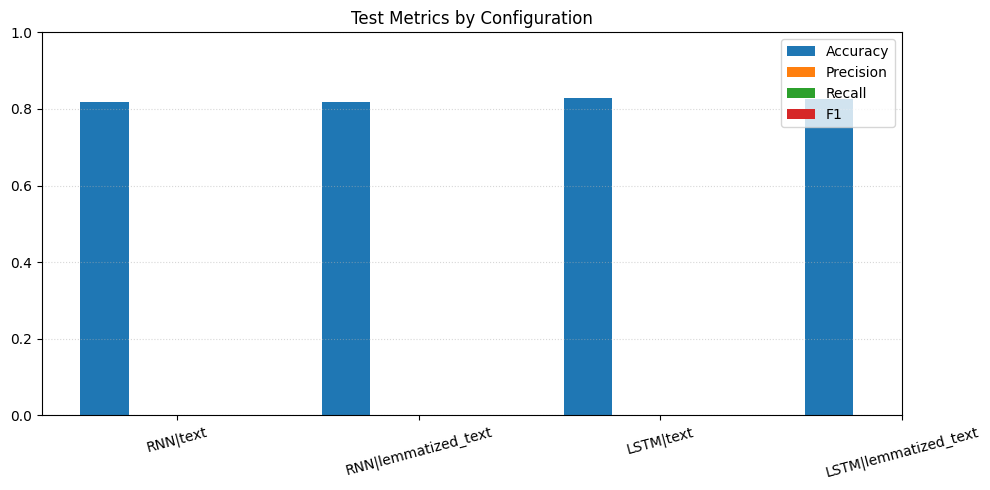

In [16]:
import matplotlib.pyplot as plt
import numpy as np

labels = [row['label'] for row in METRICS_TABLE]
accuracies = [row['test_acc'] for row in METRICS_TABLE]
f1_scores = [row['f1'] for row in METRICS_TABLE]
precision_scores = [row['precision'] for row in METRICS_TABLE]
recall_scores = [row['recall'] for row in METRICS_TABLE]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - 1.5 * width, accuracies, width, label='Accuracy')
ax.bar(x - 0.5 * width, precision_scores, width, label='Precision')
ax.bar(x + 0.5 * width, recall_scores, width, label='Recall')
ax.bar(x + 1.5 * width, f1_scores, width, label='F1')

ax.set_title('Test Metrics by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()



## Preview Predictions (Optional)
Inspect a handful of test sentences with their predicted probabilities. Toggle previews via `OPTIONS['no_preview']` or the preview count.


In [13]:
if OPTIONS['no_preview'] or OPTIONS['preview_samples'] <= 0:
    LOGGER.info('Preview disabled via configuration.')
else:
    for res in RESULTS:
        print(f"Preview for {res['label']}:")
        if not res['preview']:
            print('  No preview samples available.')
            continue
        for sample in res['preview']:
            print(
                f"  text='{sample['text']}'"
                f"    true={sample['true_label']} pred={sample['pred_label']} "
                f"prob_neg={sample['prob_negative']:.3f} prob_pos={sample['prob_positive']:.3f}"
            )

Preview for RNN|text:
  text='CS is stupid. Its warm up here  I have a sore tongue haha. Anddd mum is making cake.'    true=positive pred=negative prob_neg=0.712 prob_pos=0.288
  text='my website: LifeLineLaugh.piczo.com .... visit it! please '    true=positive pred=positive prob_neg=0.050 prob_pos=0.950
  text=' @ a f o x 9 8   T h a n k   y o u   f o r   e n d l e s s .   H a v e   S a r t o   C o m e d y   a n d   L a u r e ...'    true=positive pred=positive prob_neg=0.436 prob_pos=0.564
Preview for RNN|lemmatized_text:
  text='c be stupid . it warm up here i have a sore tongue haha . anddd mum be make cake .'    true=positive pred=negative prob_neg=0.902 prob_pos=0.098
  text='my website : lifelinelaugh.piczo.com .... visit it ! please'    true=positive pred=positive prob_neg=0.214 prob_pos=0.786
  text=' @   a f o x 9 8   t h a n k   y o u   f o r   e n d l e s s   .   h a v e   s a r t o   c o m e d y   a n d   l a u ...'    true=positive pred=positive prob_neg=0.043 prob_pos=0.